In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


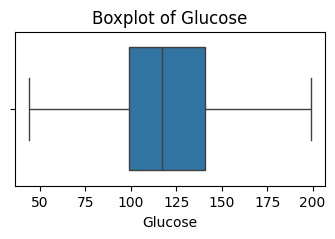

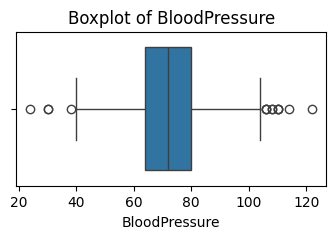

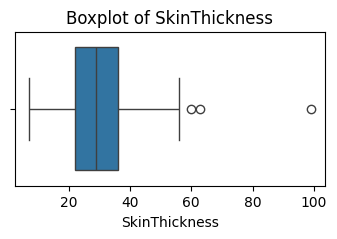

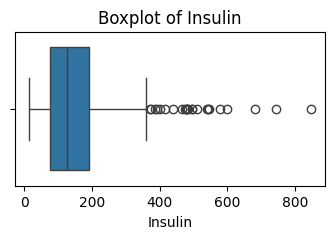

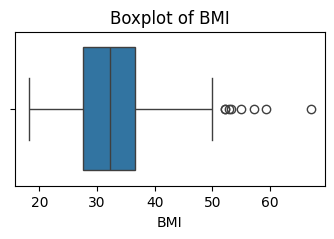

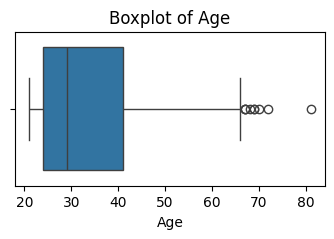

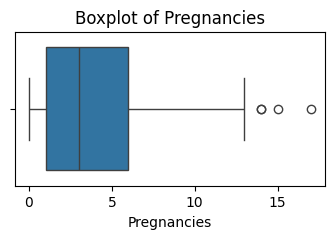

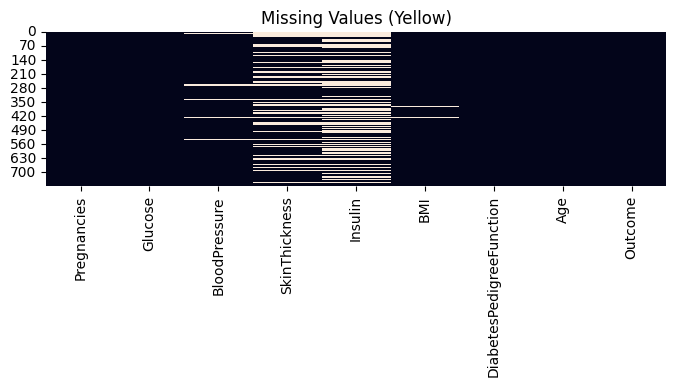

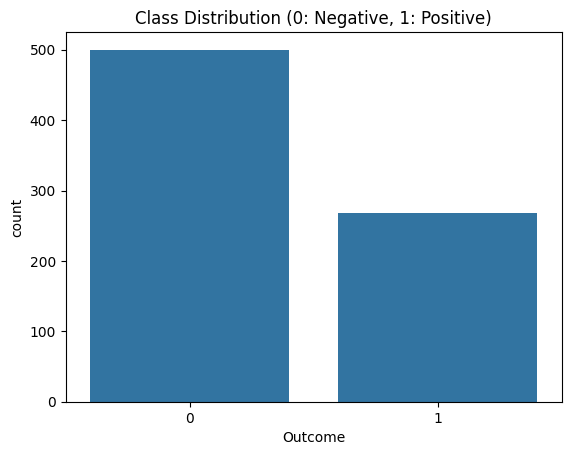

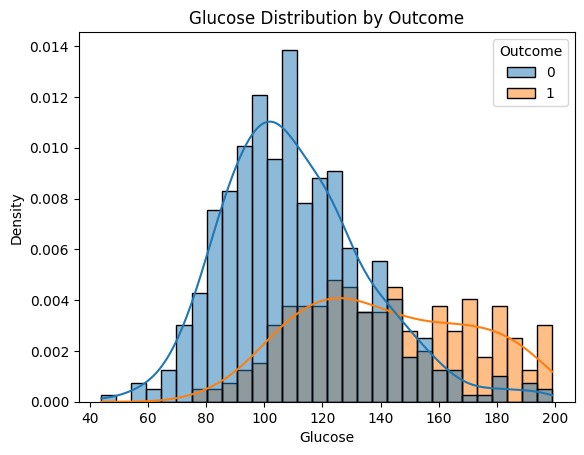

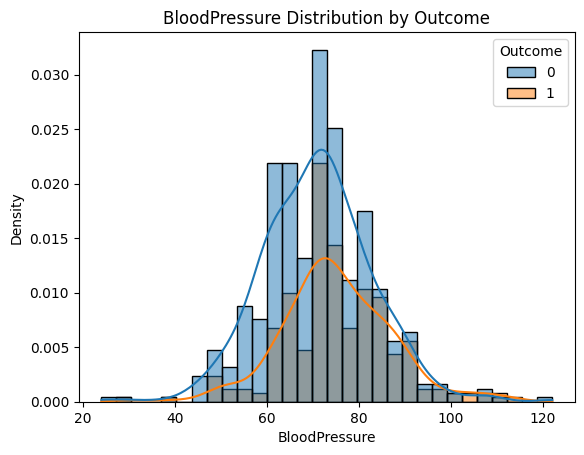

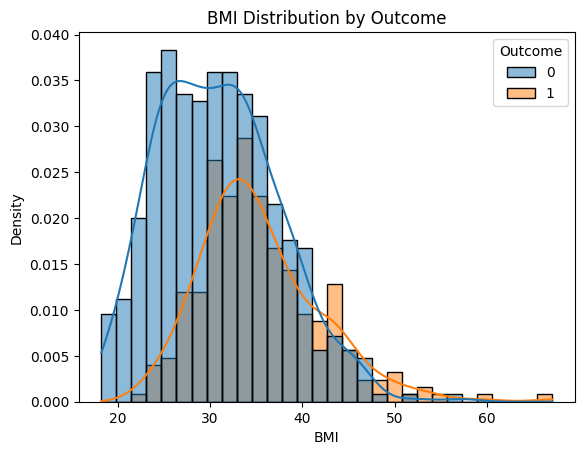

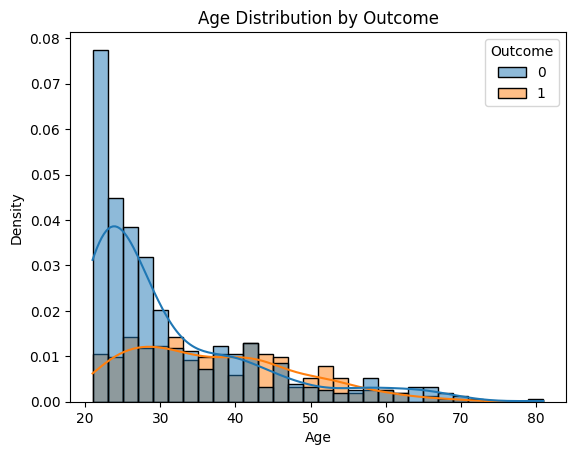

In [2]:
# 라이브러리 설치/불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로딩
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)
print(df.head())

# 2. 결측값 탐지 및 처리 (0값을 NaN으로 변환, 단, 'Pregnancies'는 0 가능)
cols_with_zero_na = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero_na] = df[cols_with_zero_na].replace(0, np.nan)
print(df.isnull().sum())

# 3. 이상치 탐지(간단히 Boxplot)
for col in cols_with_zero_na + ['Age', 'Pregnancies']:
    plt.figure(figsize=(4,2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# 4. 결측치 시각화(heatmap)
plt.figure(figsize=(8,2))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Values (Yellow)')
plt.show()

# 5. 결측값 간단 처리(중앙값으로 대체)
df[cols_with_zero_na] = df[cols_with_zero_na].fillna(df[cols_with_zero_na].median())

# 6. 데이터 시각화(클래스 분포)
sns.countplot(x='Outcome', data=df)
plt.title('Class Distribution (0: Negative, 1: Positive)')
plt.show()

# 7. 주요 변수별 분포(양성/음성)
for col in ['Glucose', 'BloodPressure', 'BMI', 'Age']:
    sns.histplot(data=df, x=col, hue='Outcome', bins=30, kde=True, stat='density')
    plt.title(f'{col} Distribution by Outcome')
    plt.show()


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 1. 특징/타겟 분리, 정규화
X = df.drop('Outcome', axis=1)
y = df['Outcome']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 학습/테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# 3. 모델 정의 (클래스 불균형: class_weight='balanced')
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=500),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=(y==0).sum()/(y==1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 4. 교차검증(AUC 기준) 및 훈련
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = {}
for name, model in models.items():
    cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    auc_scores[name] = cv_score.mean()
    print(f'{name} 평균 CV AUC: {cv_score.mean():.4f}')
    model.fit(X_train, y_train) # 추후 테스트셋 평가 위해 fit도 수행

# 모델 훈련 완료(후에 predict_proba에 사용)


Logistic Regression 평균 CV AUC: 0.8371
Random Forest 평균 CV AUC: 0.8280
SVM 평균 CV AUC: 0.8258


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:52:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:52:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:52:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:52:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:52:05] WARNING: /w

XGBoost 평균 CV AUC: 0.7758


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:52:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


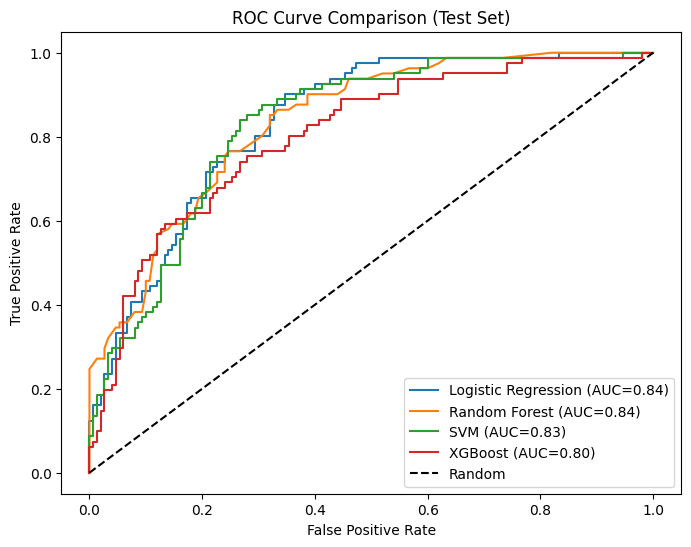


[모델별 주요 평가 지표 비교]


,Model,Accuracy,F1 Score,Precision,Recall,AUC
0,Logistic Regression,0.7619,0.6746,0.6477,0.7037,0.8366
1,Random Forest,0.7662,0.6250,0.7143,0.5556,0.8360
2,SVM,0.7273,0.5594,0.6452,0.4938,0.8290
3,XGBoost,0.7532,0.6369,0.6579,0.6173,0.8035


In [5]:
# 3단계: ROC/AUC 분석 & 평가 지표 비교
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 평가 결과 저장용
results = []

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # ROC, AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    # 주요 평가 지표 계산
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': pre,
        'Recall': rec,
        'AUC': auc
    })

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Test Set)')
plt.legend()
plt.show()

# 결과 표 출력
results_df = pd.DataFrame(results)
print('\n[모델별 주요 평가 지표 비교]')
display(results_df.round(4))